# Measure spin tune with fft

Effect of installing a kicker on the spin tune.

First track a particle launched with spin in X direction withour lattice modification,
then repeat with the kicker installed (but with totally negligle kick)


In [1]:
import xtrack as xt
import xpart as xp
import xobjects as xo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["legend.handlelength"] = 1
plt.rcParams.update({'font.size': 14})
plt.rc('font', family='serif')

### Load and configure ring model

The energy is set for a spin tune of 103.45

In [3]:
line = xt.Line.from_json('lattice/lep_sol.json')

line.particle_ref.anomalous_magnetic_moment=0.00115965218128
line.particle_ref.gamma0 = 89207.78287659843 # to have a spin tune of 103.45
#line.particle_ref.gamma0 = 39192.79847835304 # to have a spin tune of 45.45
spin_tune = line.particle_ref.anomalous_magnetic_moment[0]*line.particle_ref.gamma0[0]

print(f'Spin tune      = {spin_tune:.4f}')
print(f'Energy         = {line.particle_ref.p0c[0]/1E9:.4f} GeV')

Loading line from dict:   0%|          | 0/9667 [00:00<?, ?it/s]

Done loading line from dict.           
Spin tune      = 103.4500
Energy         = 45.5851 GeV


In [4]:
# RF ON
# RF in a single point, gives the largest 'effect'

line['vrfc231'] = 12.65  # qs=0.6 with radiation

# line['vrfc'] = 3.25 # qs=0.625 with radiation at 20 GeV

#line['vrfc'] = 0.58 # qs=0.625 with radiation at 45 GeV
#line['vrfsc'] = 2 # qs=0.625 with radiation at 45 GeV

# Solenoids and spin bumps off
line['on_solenoids'] = 0
line['on_spin_bumps'] = 0
line['on_coupling_corrections'] = 0

In [5]:
# Match tunes to those used during polarization measurements
# https://cds.cern.ch/record/282605
opt = line.match(
    method='4d',
    solve=False,
    vary=xt.VaryList(['kqf', 'kqd'], step=1e-4),
    targets=xt.TargetSet(qx=65.10, qy=71.20, tol=1e-4)
)
opt.solve()

                                             
Optimize - start penalty: 2.606                             
Matching: model call n. 9 penalty = 3.9777e-05              
Optimize - end penalty:  3.97769e-05                            


### Twiss to get $n_0$

In [6]:
line.configure_radiation('mean')
tw = line.twiss(spin=True, eneloss_and_damping=True, polarization=True)

In [7]:
tw.spin_tune_fractional

np.float64(0.4499836648029347)

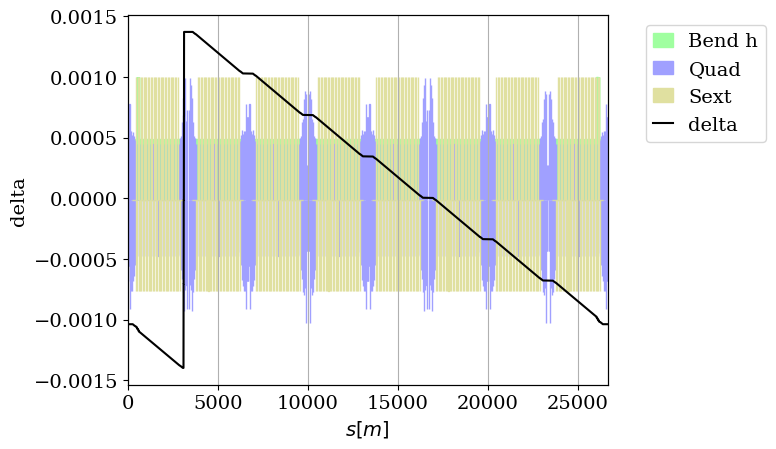

In [8]:
tw.plot("delta")

In [9]:
no_turns = 33000

 ### Track a particle (with quantum excitation) 

 We launch it with spin in X such that we get the spin tune by an FFT (due to the precession)

In [10]:
# enable spin tracking
line.configure_spin('auto')
line.build_tracker()
line.configure_radiation('quantum')

p = tw.particle_on_co.copy()

# Initialize spin along x axis !
p.spin_x = 1
p.spin_y = 0
p.spin_z = 0


line.track(p, num_turns=no_turns, turn_by_turn_monitor=True, with_progress=1000)
spin_y_scan = line.record_last_track.spin_y[0, :]
spin_x_scan = line.record_last_track.spin_x[0, :]

The line already has an associated tracker


Tracking:   0%|          | 0/33000 [00:00<?, ?it/s]

### Plot spin vs excitation frequency

Text(0.5, 0, 'Turn no.')

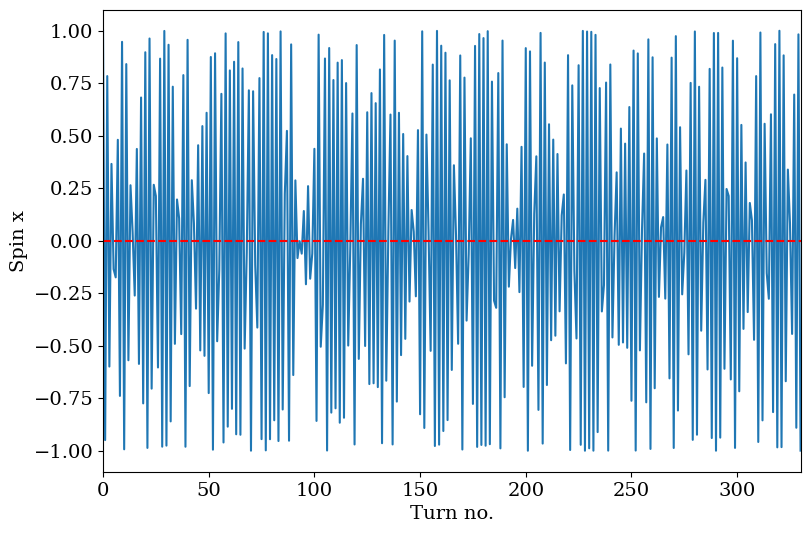

In [11]:

# Plot
plt.figure(1, figsize=(9, 6))
plt.plot(np.linspace(0,no_turns,no_turns), spin_x_scan)
plt.ylabel('Spin x')
plt.ylim(-1.1,1.1)
plt.xlim(0, no_turns/100)
plt.plot([0,no_turns], [0,0], c='red', linestyle = 'dashed')

plt.xlabel(r'Turn no.')

FFT of the x spin component

In [12]:
from scipy.fft import fft, ifft, fftfreq

In [13]:
spinXfft = fft(spin_x_scan)

nfft = len(spinXfft)
xf = fftfreq(nfft, 1)[:nfft//2]

### peak is as expected at 0.45

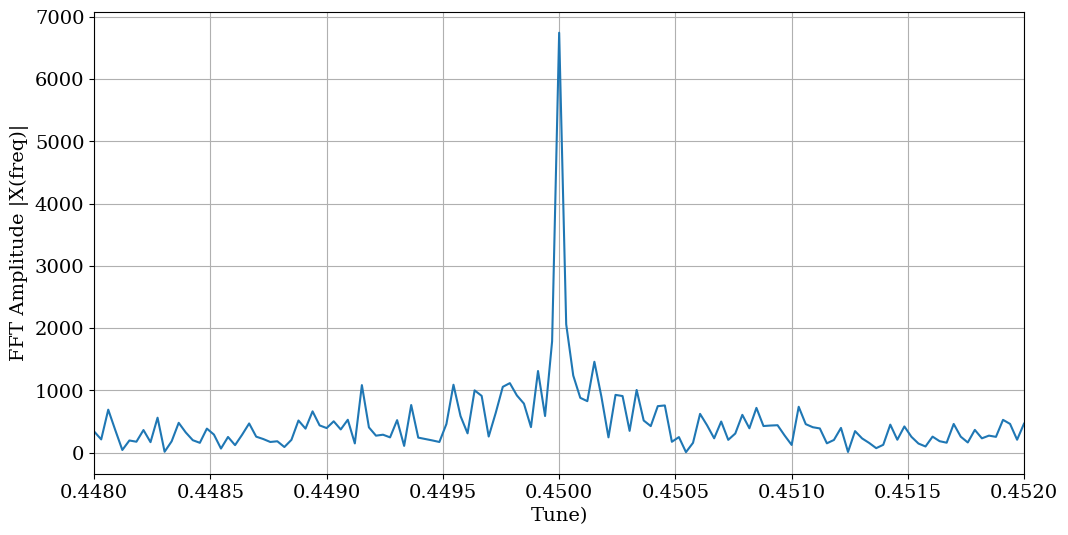

In [14]:
plt.figure(figsize = (12, 6))

#plt.stem(xf, np.abs(spinXfft[0:nfft//2]))
plt.plot(xf, np.abs(spinXfft[0:nfft//2]))
plt.grid()

plt.xlabel('Tune)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0.448, 0.452)
#plt.xlim(0.3, 0.5)
plt.show()

### Now install a kicker to have a sinusoidal excitation with changing frequency

But we set the V kick so small that it has no effect. We anyhow only monitor the spin X component for the spin tune

In [15]:
line.discard_tracker()

In [16]:
# kicker with a vanishinggly small kick !
from chirp_kicker import VerticalChirpKicker
kicker = VerticalChirpKicker(
    length=1.6, 
    k0sl=1e-20, # peak value
    q_start=0.449,
    q_span=0.002,
    num_turns=33000, # Duration of the scan
)
line.insert('spin_kicker', obj=kicker, at='bfkv1.qs18.r2@start')

Slicing line:   0%|          | 0/9550 [00:00<?, ?it/s]

In [17]:
line.build_tracker()

p2 = tw.particle_on_co.copy()

# Initialize spin along x axis !
p2.spin_x = 1
p2.spin_y = 0
p2.spin_z = 0


line.track(p2, num_turns=no_turns, turn_by_turn_monitor=True, with_progress=1000)
spin_y_scan2 = line.record_last_track.spin_y[0, :]
spin_x_scan2 = line.record_last_track.spin_x[0, :]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/33000 [00:00<?, ?it/s]

Text(0.5, 0, 'Turn no.')

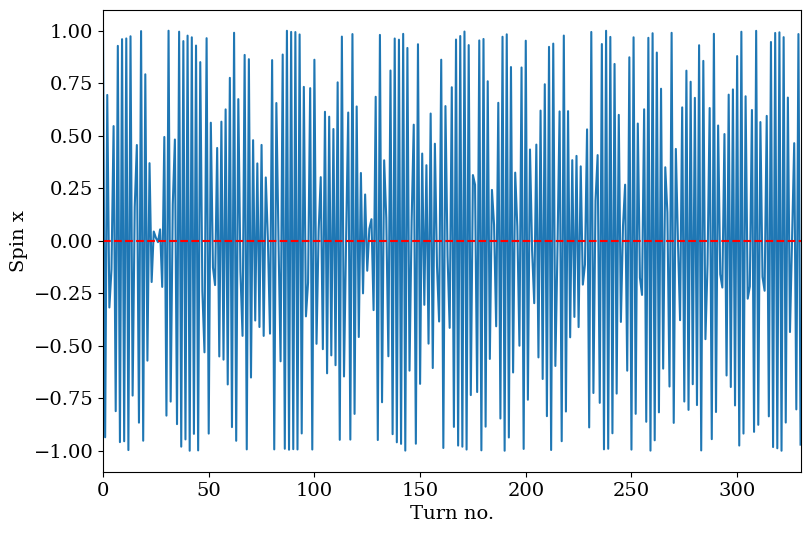

In [18]:

# Plot
plt.figure(1, figsize=(9, 6))
plt.plot(np.linspace(0,no_turns,no_turns), spin_x_scan2)
plt.ylabel('Spin x')
plt.ylim(-1.1,1.1)
plt.xlim(0, no_turns/100)
plt.plot([0,no_turns], [0,0], c='red', linestyle = 'dashed')

plt.xlabel(r'Turn no.')

In [19]:
spinXfft2 = fft(spin_x_scan2)

nfft2 = len(spinXfft2)
xf2 = fftfreq(nfft2, 1)[:nfft2//2]

### and the peak is not shifted anymore :-)

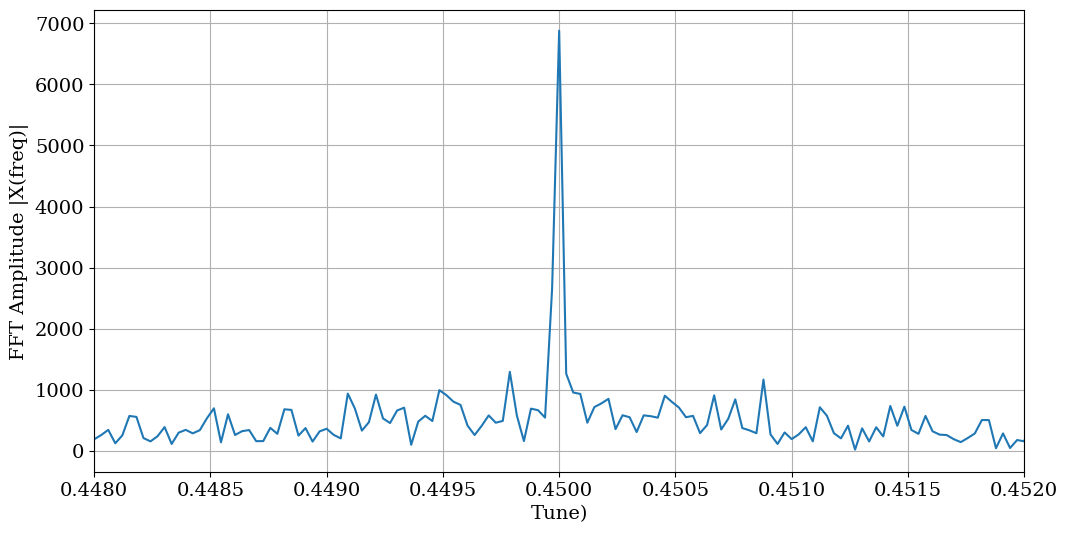

In [20]:
plt.figure(figsize = (12, 6))

#plt.stem(xf, np.abs(spinXfft[0:nfft//2]))
plt.plot(xf2, np.abs(spinXfft2[0:nfft2//2]))
plt.grid()

plt.xlabel('Tune)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0.448, 0.452)
#plt.xlim(0.3, 0.5)
plt.show()